This notebook is to determine the required laser power to illuminate the flat field screen

currently in Python 3

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.integrate import simps

In [2]:
# declare constants
h = 6.626e-34 # m2 kg / s
c = 3e8 # m/s

In [130]:
def get_white_light_source(self):
    import numpy as np
    
    # check to make sure self is a string
    #MUST INCLUDE
    
    # make self lowercase
    self = self.lower()
    
    if self == 'energetiq_99xfc_600um_fiber':
        # Load Energetiq-99XFC profile output profile (no fiber)
        # no actual profile, just guessing from the curve in the PDF file 
        filename='/Users/patrickingraham/LSST/laser_throughput_calc/Laser_power_data/Energetiq-99XFC.csv'
        energetiq_99xfc_data = np.genfromtxt(filename,
                          delimiter=',',comments='#') # wavelength [nm], Transmission
        #curve assumes a 230um diameter fiber, 1m in length
        # can use a 600µm fibre which then increases flux by a factor of ~2.25.
        fiber_diameter_multiplier = 2.25

        energetiq_99xfc_wave =      np.concatenate((energetiq_99xfc_data[:,0],np.array([1200]))) # nm
        energetiq_99xfc_flux_W_nm =  np.concatenate((energetiq_99xfc_data[:,1],
                                             np.array([25])))*1e-6*fiber_diameter_multiplier # in watts/nm
        
        data={"wave_nm":energetiq_99xfc_wave, "flux_W_nm":energetiq_99xfc_flux_W_nm,
              "fiber_diameter_multiplier":fiber_diameter_multiplier}
        return(data)

    
    if self == 'energetiq_99x':
        # Load Energetiq-99X profile output profile
        # profile esimated from the curve in the PDF file 
        filename='/Users/patrickingraham/LSST/laser_throughput_calc/Laser_power_data/Energetiq-99X.csv'
        energetiq_99x_data = np.genfromtxt(filename,
                          delimiter=',',comments='#') # wavelength [nm], Transmission

        energetiq_99x_wave =      np.concatenate((energetiq_99x_data[:,0],np.array([1000.0]))) # nm
        energetiq_99x_flux_mW_nm_mm_sr =  np.concatenate((energetiq_99x_data[:,1],
                                             np.array([0.0]))) # in mW/nm/sr/mm^2
        print("Assuming an NA beam of 0.48, and an optic of 1.4 inch diameter catching the beam")
        # want watts/nm
        NA=0.48
        angle_deg=np.arcsin(NA)*180/np.pi
        print(angle_deg)
        beam_diam_mm=1.4*25.4 # assume optic is 1.4 inch beam diameter and convert to mm - optic is 1.5' true diam

        distance = (beam_diam_mm/2) / np.tan(angle_deg*np.pi/180) # mm
        #print(distance)
        source_area=np.pi* (60e-3)/2 * (140e-3)/2  # mm^2 using 60 μm x 140 μm FWHM plasma
        solid_angle= source_area / distance**2
        collecting_area=np.pi * (beam_diam_mm/2)**2 # in mm^2

        energetiq_99x_flux_W_nm = energetiq_99x_flux_mW_nm_mm_sr * collecting_area * solid_angle / 1000 # W/nm
        
        fiber_diameter_multiplier=1.0 # just for completeness - not useful for this
        data={"wave_nm":energetiq_99x_wave, "flux_W_nm":energetiq_99x_flux_W_nm,
              "fiber_diameter_multiplier":fiber_diameter_multiplier}
        #print(energetiq_99x_flux_W_nm)
        return(data)
    
    if '-c1' in self:
        filename='/Users/patrickingraham/LSST/laser_throughput_calc/Laser_power_data/white_light_sources/C1_CollimatedHighPowerLEDs_ScaledSpectra_8.csv'

        source_raw_data = np.genfromtxt(filename,skip_header=4,
                          delimiter=',',comments='#') # wavelength [nm], Transmission
        source_labels_data = np.genfromtxt(filename,max_rows=1, dtype=str,
                          delimiter=',',comments='#') # wavelength [nm], Transmission
        #print(source_labels_data)
        # make labels all lowercase
        source_labels_data = [element.lower() for element in source_labels_data]
        # find where the source is in the csv file
        ind=(source_labels_data).index(self) 
        #print(ind)
        #print(source_labels_data[ind])
        wave_nm = source_raw_data[:,ind]
        flux_W_nm = source_raw_data[:,ind+1] / 1000.0 # input is in mW
        fiber_diameter_multiplier=1.0 # junk input
        data={"wave_nm":wave_nm, "flux_W_nm":flux_W_nm,
              "fiber_diameter_multiplier":fiber_diameter_multiplier}
        return(data)
    
    print('Lightsource not found, options are:')
    print('energetiq_99xfc_600um_fiber')
    print('energetiq_99x')
    return()


### Load source output profile

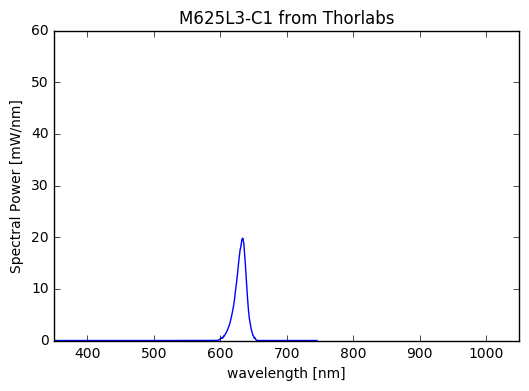

In [131]:
# assume 2inch collimators from thorlabs, sources have 1mm by 1mm sizes
#laser = 'M365LP1-C1' # u-band = 1.0 minutes at SNR = 1000 -> ~2 inch diam housing
#laser = 'M365L2-C1' # u-band = 4.0 minutes at SNR = 1000 -> ~1 inch diam housing
#laser = 'M385L2-C1' # u-band = 3.6 minutes at SNR = 1000 -> ~1 inch diam
#laser = 'M385LP1-C1' # u-band = 0.8 minutes at SNR = 1000 -> ~2 inch diam
#laser = 'M455L3-C1' # b-band = 0.6 minutes at SNR = 1000 -> ~1 inch diam
#laser = 'M660L4-C1' # r-band = 0.3 minutes at SNR = 1000 -> ~1 inch diam - source is 1.5mm x 1.5mm 
laser = 'M625L3-C1' # r-band = 0.5 minutes at SNR = 1000 -> ~1 inch diam
#laser = 'M730L4-C1' # i-band = 0.7 minutes at SNR = 1000 -> ~1 inch diam
#laser = 'M850L3-C1' # z-band = 0.3 minutes at SNR = 1000 -> ~1 inch diam
#laser = 'M940L3-C1' # y-band = 0.7 minutes at SNR = 1000 -> ~1 inch diam

source_data=get_white_light_source(laser)

laser_flux_W_nm=source_data['flux_W_nm']
laser_wave = source_data['wave_nm']
fiber_diameter_multiplier=source_data['fiber_diameter_multiplier']

if 1 == 1:
    
    if laser == 'energetiq_99x':
        conv_fact=1.0/(collecting_area * solid_angle / 1000)
        
        plt.ylim([0.001,100])
        plt.xlim([170,800])
        plt.ylabel('Spectral Radiance [mW/nm/sr/mm^2]')
        plt.xlabel('wavelength [nm]')
        plt.title(laser)
        plt.semilogy(laser_wave,laser_flux_W_nm*conv_fact/fiber_diameter_multiplier,'-g',label="Power vs wavelengh")
        
    if '-c1' in laser.lower():
        plt.ylim([0,60])
        plt.xlim([350,1050])
        plt.ylabel('Spectral Power [mW/nm]')
        plt.xlabel('wavelength [nm]')
        plt.title(laser+' from Thorlabs')
        plt.plot(laser_wave,laser_flux_W_nm*1000)
    
    #plt.legend()
    plt.show()
    plt.close()
    
        
# convert to photons
number_of_photons = laser_flux_W_nm / (h*c/(laser_wave*1e-9))  # photons per second per nm

#ind=50 # indice of interest
#print("%.4g photons at %d nm" % (number_of_photons[ind], laser_wave[ind]) )

### Load beam transfer bench profile

In [132]:
# bench depends on light source
# throughput depends on light source baffling 
# not currently included in Ming's system throughput estimate

if laser == 'energetiq_99x':
    mask_throughput=0.1 # Guess
    Flux_hitting_reflector = laser_flux_W_nm  # watts/nm
        
if '-c1' in laser.lower():
    mask_throughput=1 # Guess
    Flux_hitting_reflector = laser_flux_W_nm  # watts/nm

### Multiply by end throughput calculation from Ming/Zemax/FRED (660nm)

In [133]:
# ming says 0.02% - but that's probably optimistic - assuming 0.01% - not accounting for retro-reflector
FF_system_efficiency = mask_throughput* 0.01/100.  # screen photons to detector - 3 Al mirrors - no silver
flux_hitting_focal_plane = Flux_hitting_reflector * FF_system_efficiency # watts/nm

### Remove filter dependence

In [134]:
# must divide by filter response at 660nm first - then multiply by the desired filters
r_filter_trans0 = np.genfromtxt('/Users/patrickingraham/LSST/laser_throughput_calc/throughputs/baseline/filter_r.dat',
                          delimiter=' ',comments='#') # wavelength [nm], Transmission
r_filter_trans_660nm = scipy.interpolate.griddata(r_filter_trans0[:,0],r_filter_trans0[:,1], 660, method='linear')

filterless_flux_hitting_focal_plane = flux_hitting_focal_plane / r_filter_trans_660nm # watts/nm


### Convert from energy to photons - get photons per pixel

In [135]:
filterless_flux_hitting_focal_plane_photons = filterless_flux_hitting_focal_plane / (h*c/(laser_wave*1e-9)) # photons per second per nm
#want the number of photons per second hitting eachpixel.
#Flux_hitting_focal_plane_photons[ind]

In [136]:
total_number_of_pixels = 3.2e9 # 3.2 gigapixels
full_well = 130000 # electrons   - this is actually from DECam..

filterless_flux_per_pixel_per_second_per_nm = filterless_flux_hitting_focal_plane_photons / total_number_of_pixels 
print("Filterless photons per pixel per second %d at %d nm" % (filterless_flux_per_pixel_per_second_per_nm[ind],laser_wave[ind]) )

Filterless photons per pixel per second 0 at 325 nm


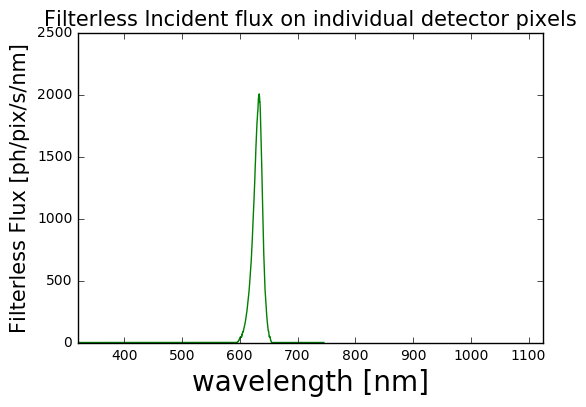

In [137]:
if 1 == 1:
    plt.plot(laser_wave,filterless_flux_per_pixel_per_second_per_nm,'-g')
    plt.title( 'Filterless Incident flux on individual detector pixels',fontsize=15)
    plt.ylabel('Filterless Flux [ph/pix/s/nm]',fontsize=15)
    plt.xlabel('wavelength [nm]',fontsize=20)
    plt.xlim([320,1125])
    #plt.text(500, 5, '**Assumes NO FILTER**')
    plt.show()
    plt.close()

### Calculate time to complete a broadband flat

In [138]:
# assume a required MEDIAN SNR for a given wavelength
med_SNR=1000.0

# load a filter (use total transmission since that is what actually
# matters and the filters have leaks that confuse the algorithm)
filter = 'r'  # ugrizy
filename='/Users/patrickingraham/LSST/laser_throughput_calc/throughputs/baseline/total_'+filter+'.dat'
total_trans000 = np.genfromtxt(filename, delimiter=' ',comments='#') # wavelength [nm], Transmission
#find nans and remove them
good = ~np.isnan(total_trans000[:,1])
total_trans0=np.transpose(np.array([total_trans000[good,0], total_trans000[good,1]]))


In [139]:
#find the X% transmission line 
min_trans=0.01
# first find the wavelength of median bandpass transmission
cen_ind, = np.where(total_trans0[:,1] > 0.3)
median_trans_value=sorted(total_trans0[cen_ind,1])[int(round(cen_ind.size / 2))]
#print median_trans_value
median_value_ind,=np.where(total_trans0[:,1] == median_trans_value)
#print median_value_ind
#print total_trans0[median_value_ind,0]

# smooth by a few nm to help find the desired transmission boundary % level
tmp= np.convolve(total_trans0[:,1], [0,1,1,1,0], mode='same')

if 0==1:
    plt.plot(total_trans0[:,0],total_trans0[:,1],'-r')
    plt.show()
    plt.close()
    
blue_side_trans_ind2,=np.where( (abs(tmp[0:median_value_ind]-min_trans)) == 
                               (np.nanmin(abs(tmp[0:median_value_ind]-min_trans))) )
red_side_trans_ind2,=np.where( (abs(tmp[median_value_ind::]-min_trans)) == 
                              (np.nanmin(abs(tmp[median_value_ind::]-min_trans))) )

print('blue side minimum total transmission (%0.2f) wavelength is %d nm' % (min_trans,total_trans0[blue_side_trans_ind2,0]) )
print('red side minimum total transmission (%0.2f) wavelength is %d nm' % (min_trans,total_trans0[median_value_ind+red_side_trans_ind2,0]) )


blue side minimum total transmission (0.01) wavelength is 523 nm
red side minimum total transmission (0.01) wavelength is 706 nm


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


count rate for r-band is 32635 photons/s/pixel


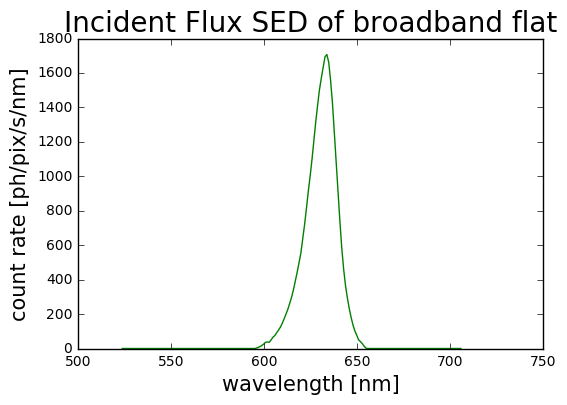

In [140]:

# define filter bandpass range
filter_bandpass = np.arange(total_trans0[blue_side_trans_ind2,0],
                            total_trans0[median_value_ind+red_side_trans_ind2,0])

# load detector efficiency
det_filename='/Users/patrickingraham/LSST/laser_throughput_calc/throughputs/baseline/detector_120227.dat'
detector0 = np.genfromtxt(det_filename, delimiter='',comments='#') # wavelength [nm], Transmission
#interpolate to filter_bandpass
detector_efficiency = scipy.interpolate.griddata(detector0[:,0],detector0[:,1], filter_bandpass, method='linear')

# load the filter curve
filename='/Users/patrickingraham/LSST/laser_throughput_calc/throughputs/baseline/filter_'+filter+'.dat'
filter_trans0 = np.genfromtxt(filename, delimiter=' ',comments='#') # wavelengt
#get filter transmission for this bandpass
filter_transmission = scipy.interpolate.griddata(filter_trans0[:,0],
                                                 filter_trans0[:,1], filter_bandpass, method='linear')

# determine filterless and detectorless count rate average
filterless_count_rate = scipy.interpolate.griddata(laser_wave,filterless_flux_per_pixel_per_second_per_nm,
                                                   filter_bandpass, method='linear') # ph/pix/s/nm
count_rate = filterless_count_rate * filter_transmission * detector_efficiency # ph/pix/s/nm

#remove nans and integrate
integrated_count_rate = simps(count_rate[~np.isnan(count_rate)], filter_bandpass[~np.isnan(count_rate)])
print('count rate for %s-band is %d photons/s/pixel' % (filter ,integrated_count_rate) )

# plot measured flux
if 1 == 1:
    plt.plot(filter_bandpass,count_rate,'-g')
    plt.title( 'Incident Flux SED of broadband flat',fontsize=20)
    plt.ylabel('count rate [ph/pix/s/nm]',fontsize=15)
    plt.xlabel('wavelength [nm]',fontsize=15)
    plt.show()
    plt.close()

In [141]:

# determine how long it will take to collect med_SNR^2 of photons
time = (med_SNR**2) / integrated_count_rate / 3600  # in hours
print('%s-band will take %0.1f minutes for an median SNR of %d' % (filter,time*60,med_SNR) )



r-band will take 0.5 minutes for an median SNR of 1000
